In [1]:
# Import necessary libraries
import torch
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
from anndata import AnnData
import sys
import time

# Add the src directory to the path
sys.path.append('joint/src')

# Import our custom modules
from data import prepare_data
from eval import evaluate_imputation
from utils import *

from model import joint_model

# Set random seeds for reproducibility
np.random.seed(10042)
torch.manual_seed(10042)

# Check if CUDA is available
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda:1


In [2]:
# Create output directory
output_dir = "./results"
os.makedirs(output_dir, exist_ok=True)

In [3]:
# Load data
# Replace these paths with your actual data paths
vi_path = "/home/pjiangag/main/mm/siid/BRCA/cast_output/visium_aligned.h5ad"
xe_path = "/home/pjiangag/main/mm/siid/BRCA/cast_output/xenium_aligned.h5ad"

print(f"Loading data from {vi_path} and {xe_path}")
vi = sc.read_h5ad(vi_path)
xe = sc.read_h5ad(xe_path)

print(f"Visium data shape: {vi.shape}")
print(f"Xenium data shape: {xe.shape}")

sc.pp.filter_genes(vi, min_cells=0.1*vi.shape[0])
sc.pp.filter_cells(vi, min_counts=0.01*vi.shape[1])

sc.pp.filter_genes(xe, min_cells=0.1*xe.shape[0])
sc.pp.filter_cells(xe, min_counts=0.01*xe.shape[1])

print(f"Visium data shape: {vi.shape}")
print(f"Xenium data shape: {xe.shape}")


Loading data from /home/pjiangag/main/mm/siid/BRCA/cast_output/visium_aligned.h5ad and /home/pjiangag/main/mm/siid/BRCA/cast_output/xenium_aligned.h5ad
Visium data shape: (4992, 18085)
Xenium data shape: (167780, 313)
Visium data shape: (4987, 12736)
Xenium data shape: (165777, 184)


In [4]:
# Examine the data
print("Visium data:")
print(vi)
print("\nXenium data:")
print(xe)

# Check if spatial coordinates exist
print("\nVisium spatial coordinates shape:", vi.obsm['spatial'].shape if 'spatial' in vi.obsm else "Not found")
print("Xenium spatial coordinates shape:", xe.obsm['spatial'].shape if 'spatial' in xe.obsm else "Not found")

Visium data:
AnnData object with n_obs × n_vars = 4987 × 12736
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'spatialdata_attrs'
    obsm: 'spatial'

Xenium data:
AnnData object with n_obs × n_vars = 165777 × 184
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

Visium spatial coordinates shape: (4987, 2)
Xenium spatial coordinates shape: (165777, 2)


In [5]:
# Find intersection of genes and randomly select 1/10 as holdout genes
all_genes = list(set(vi.var_names).intersection(set(xe.var_names)))
print(f"Number of genes in intersection: {len(all_genes)}")

# Set random seed for reproducibility
np.random.seed(10042)

# Randomly select 1/10 of intersection genes as holdout genes
n_holdout = max(1, int(len(all_genes) / 10))
holdout_genes = np.random.choice(all_genes, size=n_holdout, replace=False).tolist()

print(f"Randomly selected {len(holdout_genes)} holdout genes out of {len(all_genes)} intersection genes")
print(f"First 5 holdout genes: {holdout_genes[:5]}")

Number of genes in intersection: 181
Randomly selected 18 holdout genes out of 181 intersection genes
First 5 holdout genes: ['SLAMF7', 'GZMA', 'IGF1', 'SMS', 'C1QA']


In [6]:
# Prepare data
print(f"Preparing data with {len(holdout_genes)} holdout genes")
sorted_vi, sorted_xe, gamma = prepare_data(vi, xe, holdout_genes)

print(f"Processed Visium data shape: {sorted_vi.shape}")
print(f"Processed Xenium data shape: {sorted_xe.shape}")

# Save a copy of the original data for the holdout genes
holdout_xe = xe[:, holdout_genes].copy()
print(f"Holdout data shape: {holdout_xe.shape}")

Preparing data with 18 holdout genes
Processed Visium data shape: (4987, 181)
Processed Xenium data shape: (165777, 163)
Holdout data shape: (165777, 18)


In [7]:
# Define model parameters
hdim = 20  # Number of latent factors
ent_div = 500  # Entropy regularization denominator
lr = 1e-2  # Learning rate
epochs = 5000  # Reduced for testing, use 5000 for full training
k_neighbors_xenium = 40  # Number of neighbors for spatial graph
k_neighbors_visium = 20  # Number of neighbors for spatial graph
gcn_hidden_dim = 64  # Hidden dimension for GCN layers

In [8]:
# Initialize the joint model
print(f"Initializing model")
model = joint_model(
    xe=sorted_xe,
    vi=sorted_vi,
    gamma=gamma,
    n_factors=hdim,
    device=device,
    adaptive_entropy=True,
    adaptive_entropy_denominator=ent_div,
    poisson_sum=True,
    add_entropy=True,
    k_neighbors_xenium=k_neighbors_xenium,
    k_neighbors_visium=k_neighbors_visium,
    gcn_hidden_dim=gcn_hidden_dim,
    lambda_x = 1.0
)

Initializing model


In [9]:
# Ensure all model parameters are on the correct device
for param in model.parameters():
    if param.device != torch.device(device):
        param.data = param.data.to(device)

# Also ensure edge indices are on the correct device
model.edge_index = model.edge_index.to(device)
model.v2x_edge_index = model.v2x_edge_index.to(device)

In [10]:
# Train the model
print(f"Training model for {epochs} epochs")
start_time = time.time()

results = model.train(
    num_epochs=epochs,
    lr=lr,
    print_freq=100,
    loss_type='poisson',
)

training_time = time.time() - start_time
print(f"Training finished in {training_time:.2f} seconds")

losses = results['losses']

Training model for 5000 epochs
Training the model with poisson loss
Epoch 0, Loss: 164147200.0000, Xenium loss: 147778176.0000, Visium loss: 16369028.0000, Regularization: 3.0479, Entropy: -2.9957
New best loss: 164147200.0000
Epoch 100, Loss: 109060944.0000, Xenium loss: 103091760.0000, Visium loss: 5969134.0000, Regularization: 44.6762, Entropy: -3.0625
New best loss: 109060944.0000
Epoch 200, Loss: 68136984.0000, Xenium loss: 69284480.0000, Visium loss: -1147595.0000, Regularization: 94.6399, Entropy: -3.2767
New best loss: 68136984.0000
Epoch 300, Loss: 39417136.0000, Xenium loss: 44802016.0000, Visium loss: -5384979.0000, Regularization: 101.7037, Entropy: -3.9398
New best loss: 39417136.0000
Epoch 400, Loss: 19644908.0000, Xenium loss: 25850816.0000, Visium loss: -6206014.5000, Regularization: 105.4774, Entropy: -4.7621
New best loss: 19644908.0000
Epoch 500, Loss: 6747563.5000, Xenium loss: 13161800.0000, Visium loss: -6414345.0000, Regularization: 108.4642, Entropy: -5.7595
New

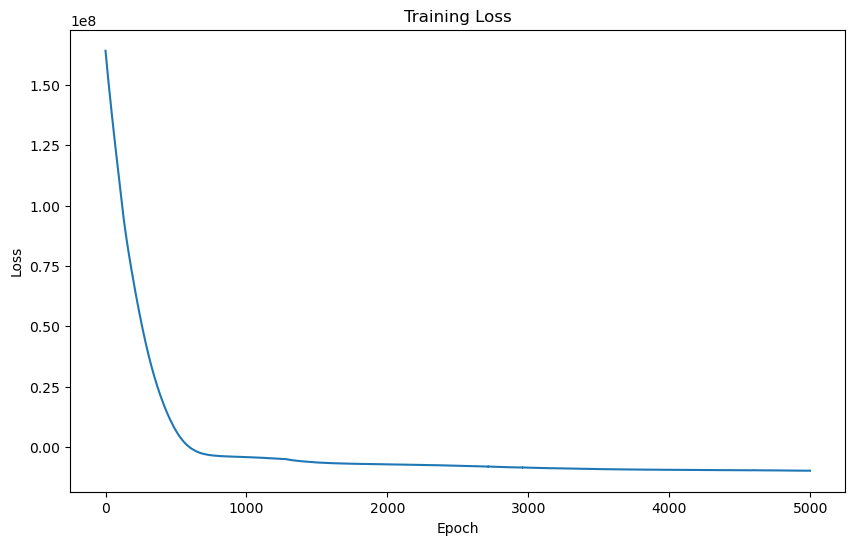

In [11]:
# Plot loss curve
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.savefig(os.path.join(output_dir, 'loss_curve.png'))
plt.show()

In [12]:
# Get predictions for holdout genes
print("Generating predictions")
model.eval()
with torch.no_grad():
    xenium_est = model.get_xenium_est().cpu().numpy()

# Create AnnData object with predictions
full_pred = AnnData(X=xenium_est, obs=sorted_xe.obs, var=sorted_vi.var)

# Extract predictions for holdout genes
imputed = full_pred[:, holdout_genes].copy()
print(f"Imputed data shape: {imputed.shape}")

Generating predictions
Training the model with poisson loss
Imputed data shape: (165777, 18)


Evaluating predictions
Evaluation metrics:
  R²: 0.0799
  PCC: 0.2826
  MAE: 0.8392
  SSIM: 0.2994
  RMSE: 1.1978
  JS: 6.9654
  NNZ: 0.4638
  Cell-wise R²: 0.1596
  Gene-wise R²: 0.1094
r2: 0.07986091462893867
pcc: 0.2825967073440552
mae: 0.839186429977417
ssim: 0.2994169956703625
rmse: -1.1978338738178353
js: -6.96543025970459
nnz: 0.4637552488235907
cell_r2: 0.1595806892977033
gene_r2: 0.1093996377447726


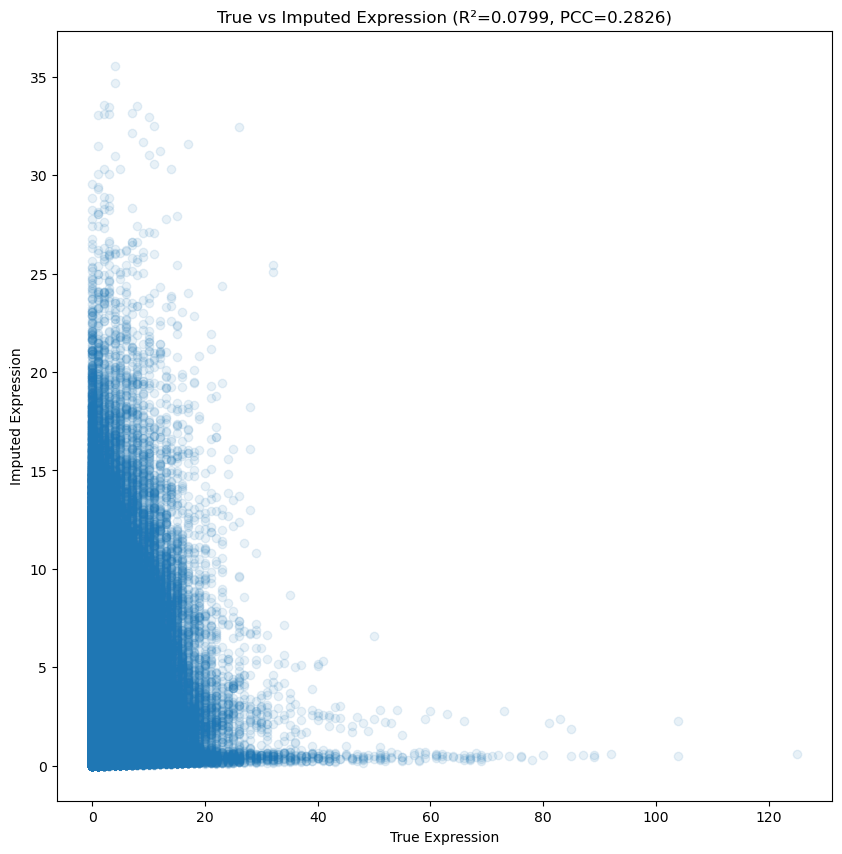

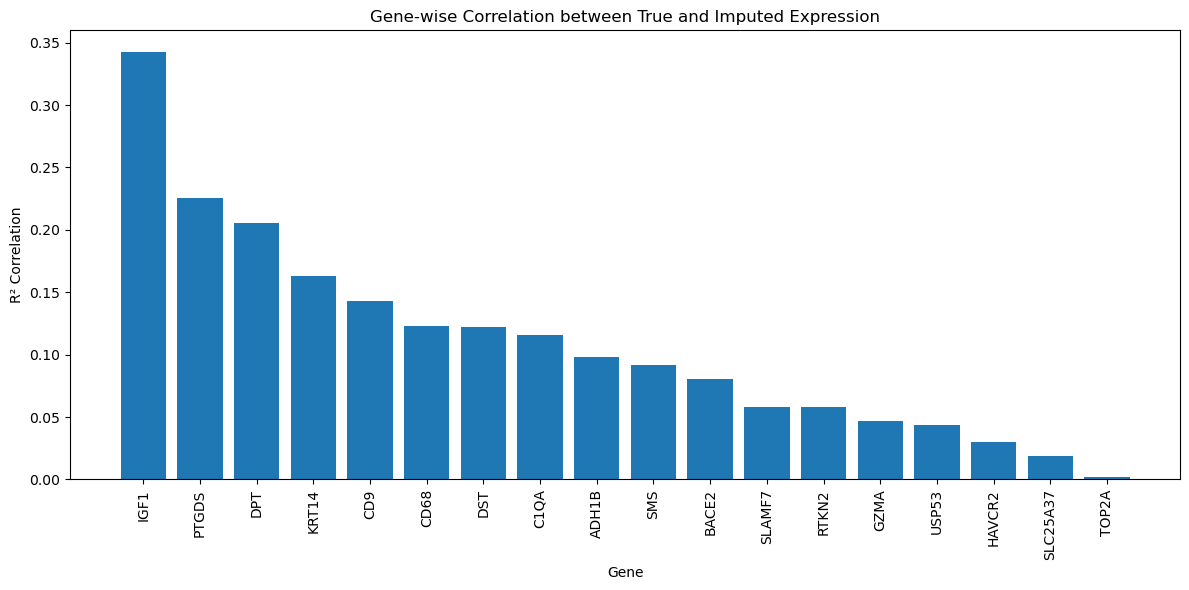

In [15]:
# Evaluate predictions
print("Evaluating predictions")
metrics = evaluate_imputation(holdout_xe, imputed, output_dir)

# Print metrics
for key, value in metrics.items():
    print(f"{key}: {value}")

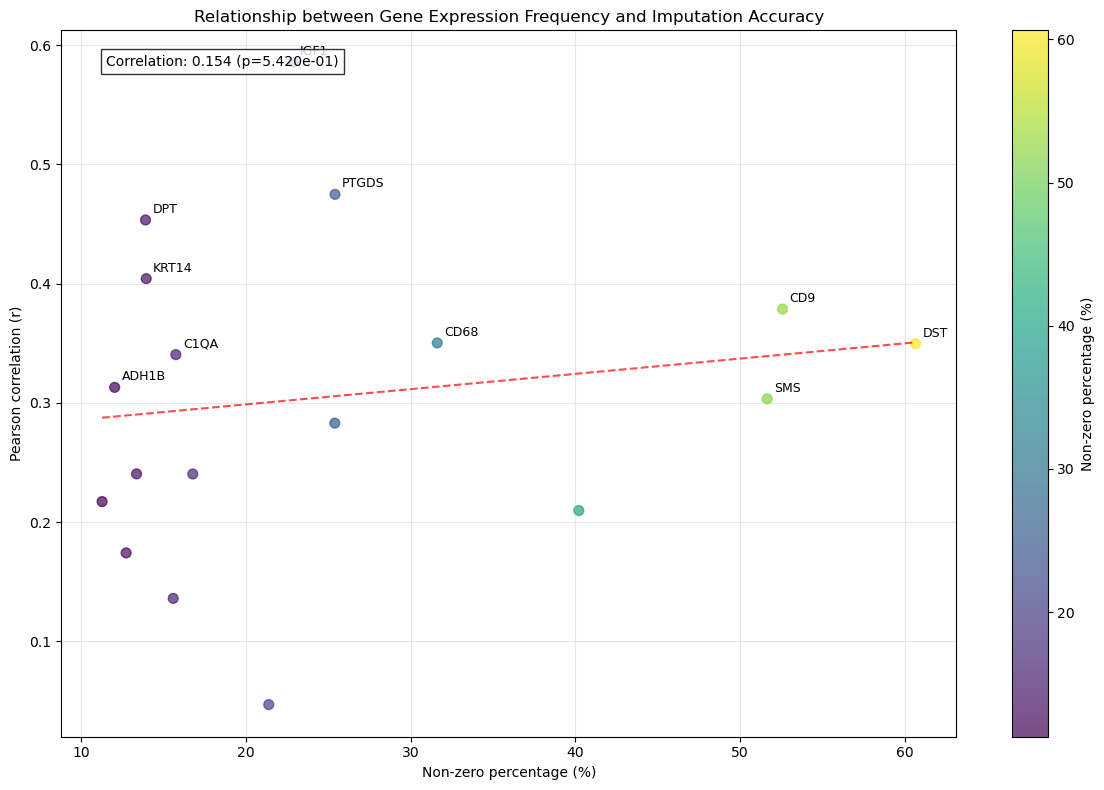

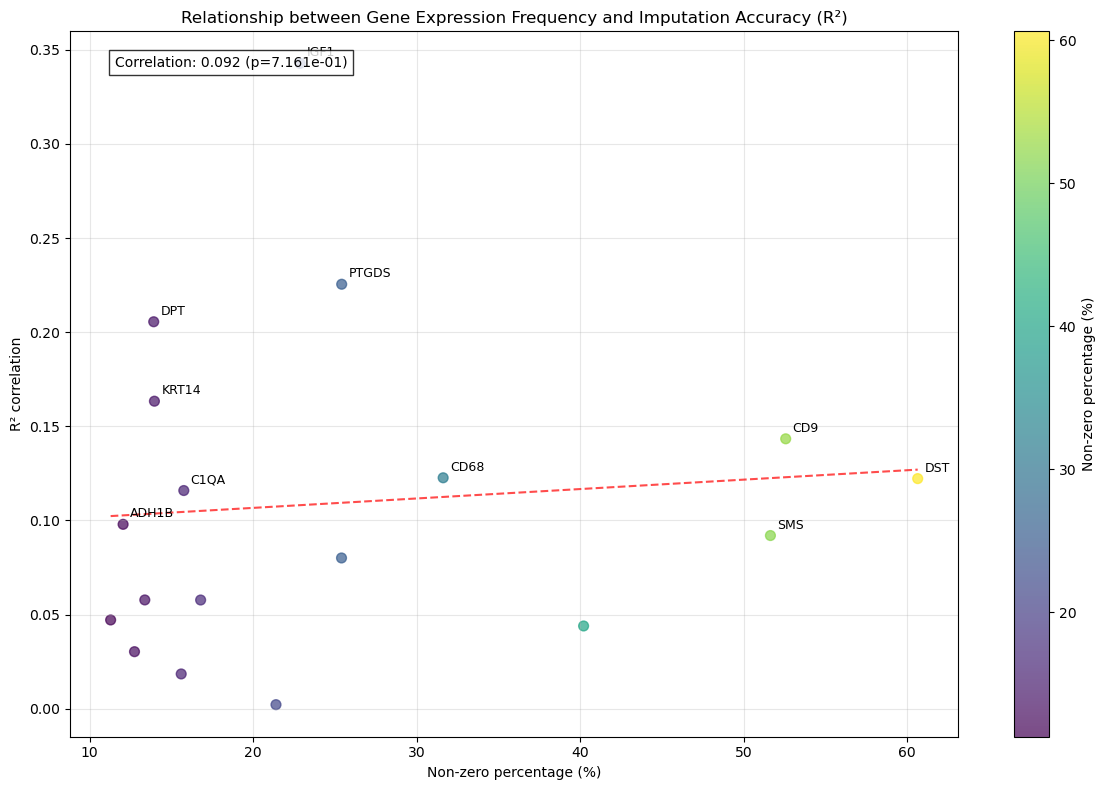

In [16]:
# Calculate non-zero percentage and R² correlation for each gene in holdout genes
gene_stats = []

for gene in holdout_genes:
    # Get true expression
    true_expr = holdout_xe[:, gene].X
    if not isinstance(true_expr, np.ndarray):
        true_expr = true_expr.toarray()
    true_expr = true_expr.flatten()
    
    # Get imputed expression
    imputed_expr = imputed[:, gene].X
    if not isinstance(imputed_expr, np.ndarray):
        imputed_expr = imputed_expr.toarray()
    imputed_expr = imputed_expr.flatten()
    
    # Calculate non-zero percentage
    nonzero_pct = (true_expr > 0).mean() * 100
    
    # Calculate correlation
    from scipy.stats import pearsonr
    corr, _ = pearsonr(true_expr, imputed_expr)
    
    gene_stats.append({
        'gene': gene,
        'nonzero_pct': nonzero_pct,
        'r2': corr**2,  # Convert Pearson r to R²
        'r': corr       # Keep Pearson r as well
    })

# Convert to DataFrame for easier plotting
import pandas as pd
gene_df = pd.DataFrame(gene_stats)

# Create scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(gene_df['nonzero_pct'], gene_df['r'], 
                     alpha=0.7, s=50, c=gene_df['nonzero_pct'], cmap='viridis')

# Add gene labels for top genes
top_genes = gene_df.sort_values('r', ascending=False).head(10)
for _, row in top_genes.iterrows():
    plt.annotate(row['gene'], 
                xy=(row['nonzero_pct'], row['r']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=9)

# Add trend line
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(gene_df['nonzero_pct'], gene_df['r'])
x_line = np.linspace(gene_df['nonzero_pct'].min(), gene_df['nonzero_pct'].max(), 100)
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, 'r--', alpha=0.7)

# Add correlation between non-zero percentage and R
plt.text(0.05, 0.95, f'Correlation: {r_value:.3f} (p={p_value:.3e})', 
         transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(facecolor='white', alpha=0.8))

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Non-zero percentage (%)')

# Customize plot
plt.xlabel('Non-zero percentage (%)')
plt.ylabel('Pearson correlation (r)')
plt.title('Relationship between Gene Expression Frequency and Imputation Accuracy')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the figure
plt.savefig(os.path.join(output_dir, 'gene_nonzero_vs_correlation.png'), dpi=300)
plt.show()

# You can also create a version with R² instead of r if preferred
plt.figure(figsize=(12, 8))
scatter = plt.scatter(gene_df['nonzero_pct'], gene_df['r2'], 
                     alpha=0.7, s=50, c=gene_df['nonzero_pct'], cmap='viridis')

# Add gene labels for top genes
top_genes = gene_df.sort_values('r2', ascending=False).head(10)
for _, row in top_genes.iterrows():
    plt.annotate(row['gene'], 
                xy=(row['nonzero_pct'], row['r2']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=9)

# Add trend line
slope, intercept, r_value, p_value, std_err = linregress(gene_df['nonzero_pct'], gene_df['r2'])
x_line = np.linspace(gene_df['nonzero_pct'].min(), gene_df['nonzero_pct'].max(), 100)
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, 'r--', alpha=0.7)

plt.text(0.05, 0.95, f'Correlation: {r_value:.3f} (p={p_value:.3e})', 
         transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(facecolor='white', alpha=0.8))

plt.colorbar(scatter).set_label('Non-zero percentage (%)')
plt.xlabel('Non-zero percentage (%)')
plt.ylabel('R² correlation')
plt.title('Relationship between Gene Expression Frequency and Imputation Accuracy (R²)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'gene_nonzero_vs_r2.png'), dpi=300)
plt.show()

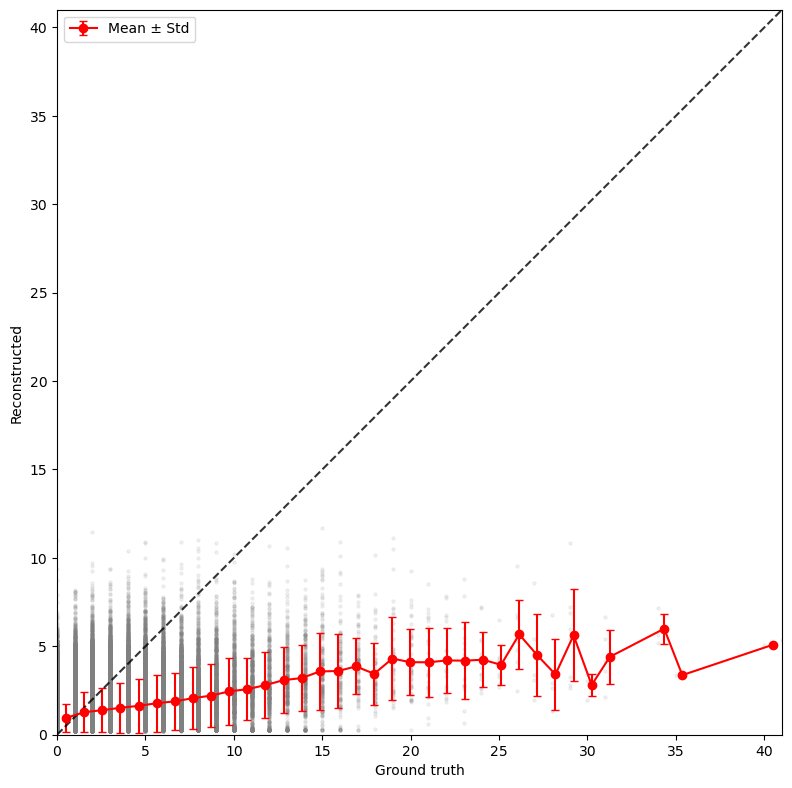

In [17]:
g = 'DST'

ground_truth = xe[:, g].X.toarray().flatten()
reconstructed = imputed[:, g].X.toarray().flatten()

max_val = np.max([np.max(ground_truth), np.max(reconstructed)])

# ... existing code ...

# Create binned statistics
bins = np.linspace(0, max_val, int(max_val))  # Create 20 bins
bin_centers = (bins[:-1] + bins[1:]) / 2
means = []
stds = []
for i in range(len(bins)-1):
    mask = (ground_truth >= bins[i]) & (ground_truth < bins[i+1])
    if np.sum(mask) > 0:  # Only calculate if bin has data
        means.append(np.mean(reconstructed[mask]))
        stds.append(np.std(reconstructed[mask]))
    else:
        means.append(np.nan)
        stds.append(np.nan)
means = np.array(means)
stds = np.array(stds)

# Create the plot
plt.figure(figsize=(8, 8))

# Plot individual points with low opacity
plt.scatter(ground_truth, reconstructed, alpha=0.1, s=5, color='gray')

# Plot means and standard deviations
valid_mask = ~np.isnan(means)
plt.errorbar(bin_centers[valid_mask], means[valid_mask], 
            yerr=stds[valid_mask], fmt='o-', color='red', 
            capsize=3, capthick=1, label='Mean ± Std')

# Add diagonal line
plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.8)

# Customize axes
plt.xlabel('Ground truth')
plt.ylabel('Reconstructed')
plt.xlim(0, max_val)
plt.ylim(0, max_val)
plt.gca().set_aspect('equal')

# Add R² score
# plt.text(0.05*max_val, 0.95*max_val, f'R² = {r2:.3f}', fontsize=12)

plt.legend()
plt.tight_layout()
plt.show()

Factors shape: (165777, 20)
Loadings shape: (20, 181)


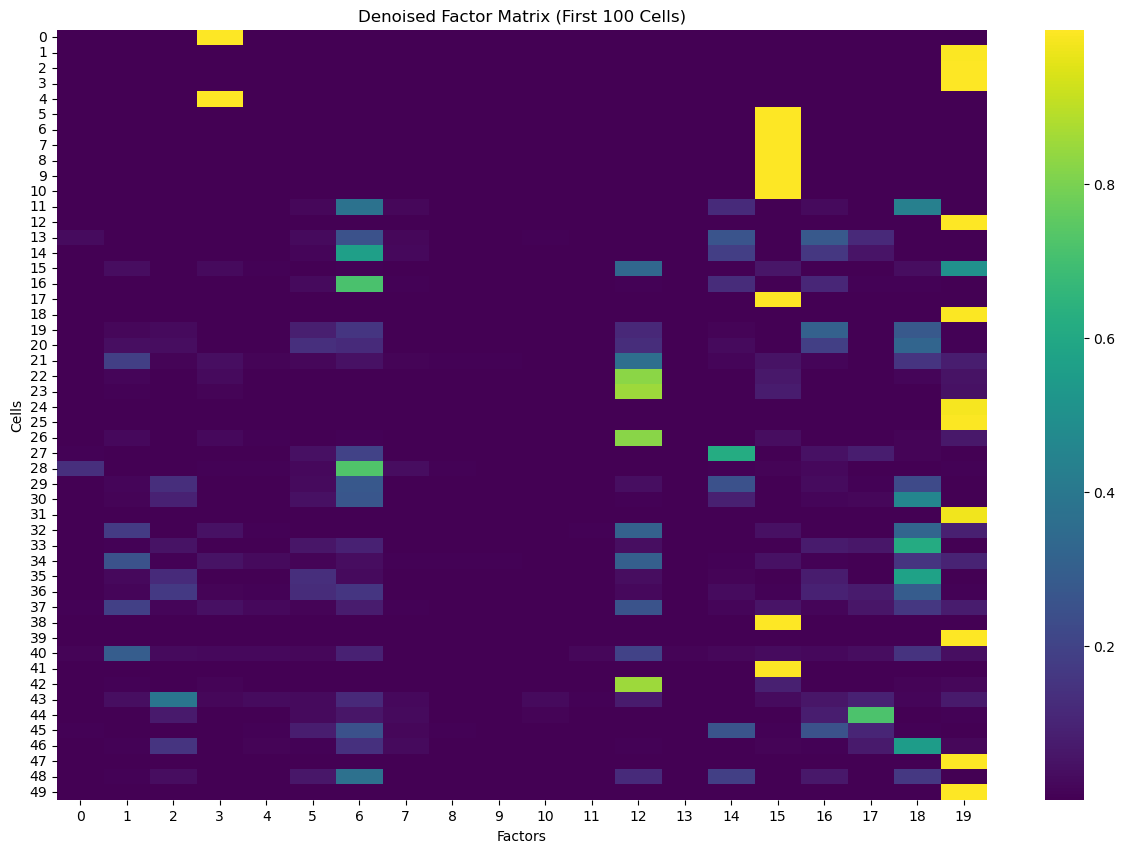

In [18]:
# Visualize factors
with torch.no_grad():
    factors = model.F_soft.cpu().numpy()
    loadings = model.W_soft.cpu().numpy()

print(f"Factors shape: {factors.shape}")
print(f"Loadings shape: {loadings.shape}")

plt.figure(figsize=(15, 10))
sns.heatmap(factors[:50, :], cmap='viridis')
plt.xlabel('Factors')
plt.ylabel('Cells')
plt.title('Denoised Factor Matrix (First 100 Cells)')
plt.savefig(os.path.join(output_dir, 'factor_heatmap.png'))
plt.show()

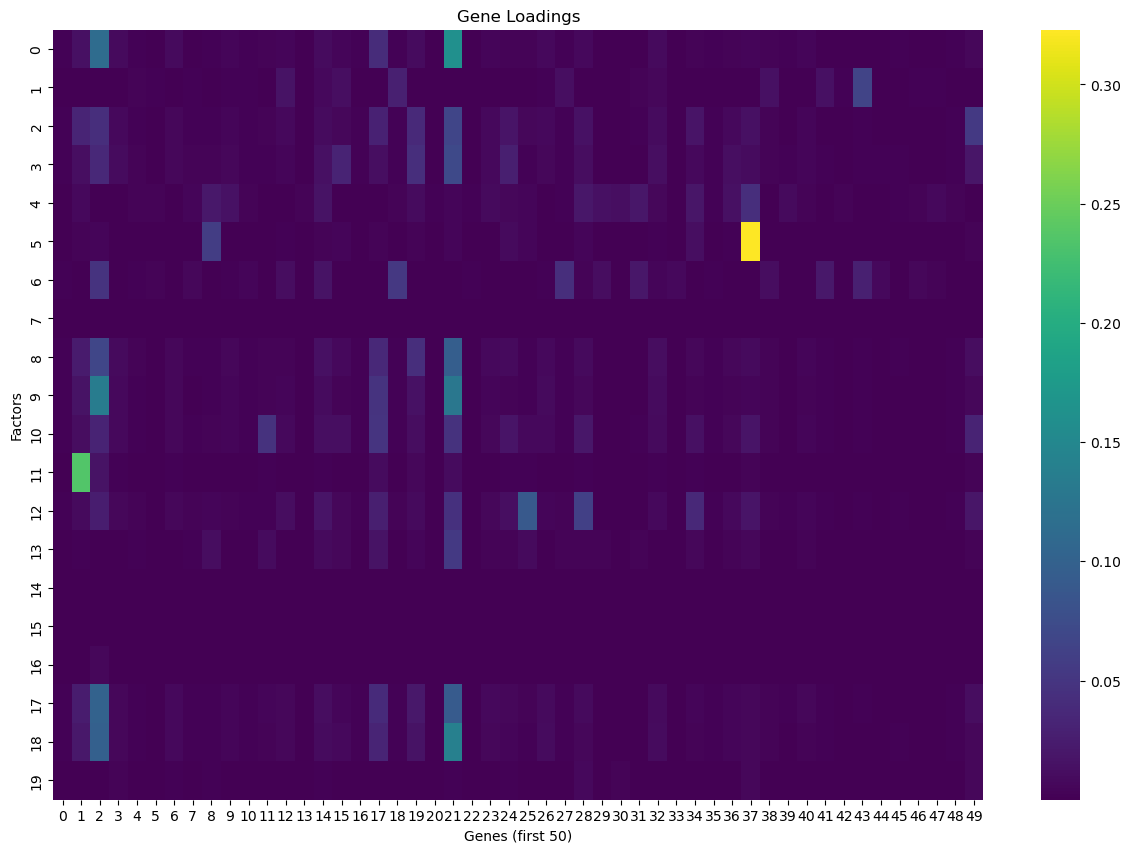

In [19]:
# Visualize loadings
plt.figure(figsize=(15, 10))
sns.heatmap(loadings[:, :50], cmap='viridis')
plt.xlabel('Genes (first 50)')
plt.ylabel('Factors')
plt.title('Gene Loadings')
plt.savefig(os.path.join(output_dir, 'loading_heatmap.png'))
plt.show()

In [20]:
ret_x = dcn(model.xenium_factors)
ret_v = dcn(model.visium_factors)
Px = AnnData(X = ret_x, obs = sorted_xe.obs, obsm = sorted_xe.obsm)
Pv = AnnData(X = ret_v, obs = sorted_vi.obs, obsm = sorted_vi.obsm)

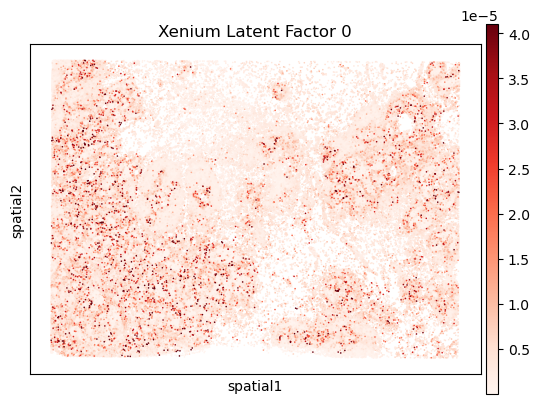

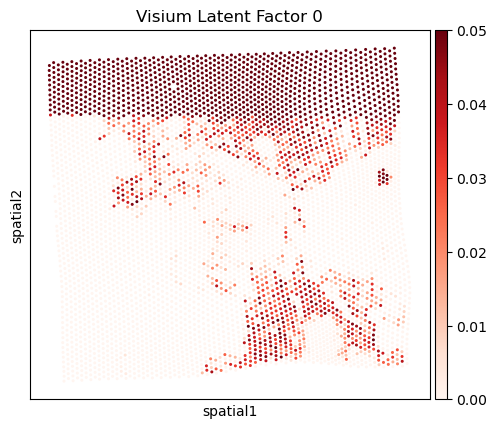

In [21]:
for i in range(20):
    Px.obs[i] = Px.X[:, i]
    Pv.obs[i] = Pv.X[:, i]
sc.pl.spatial(Px, color = [0], spot_size=5, title = "Xenium Latent Factor 0", color_map = "Reds")
sc.pl.spatial(Pv, color = [0], spot_size=10, title = "Visium Latent Factor 0", color_map = "Reds")

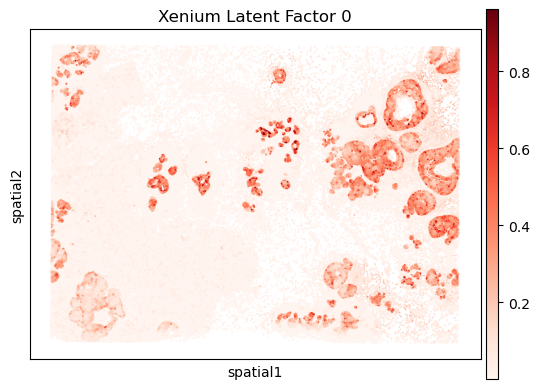

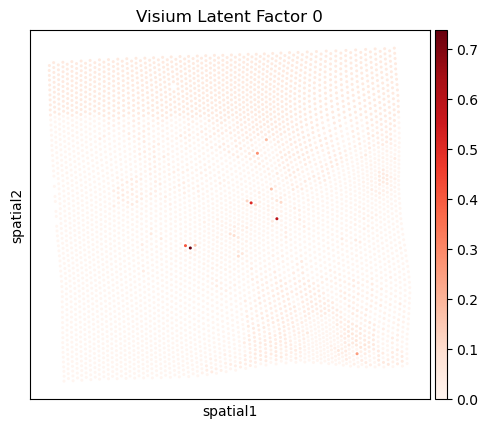

In [22]:
for i in range(20):
    Px.obs[i] = Px.X[:, i]
    Pv.obs[i] = Pv.X[:, i]
sc.pl.spatial(Px, color = [1], spot_size=5, title = "Xenium Latent Factor 0", color_map = "Reds")
sc.pl.spatial(Pv, color = [1], spot_size=10, title = "Visium Latent Factor 0", color_map = "Reds")

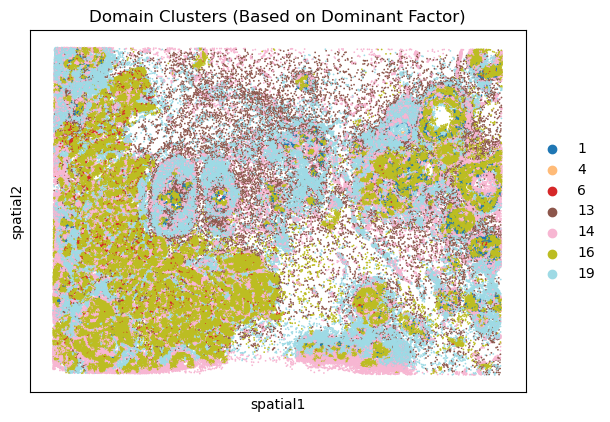

In [23]:
# Get the dominant factor (cluster) for each spot
dominant_factors = np.argmax(Px.X, axis=1)

# Create a new AnnData object
adata_factors = sc.AnnData(Px.X)
adata_factors.obsm['spatial'] = xe.obsm['spatial']
adata_factors.obs['dominant_factor'] = dominant_factors.astype(str)

# Visualize the clustering results based on dominant factors
sc.pl.spatial(adata_factors, color=['dominant_factor'], spot_size=5, 
              title="Domain Clusters (Based on Dominant Factor)", 
              palette='tab20')

In [29]:
# Create a new AnnData object with the latent factors as the main matrix
adata_factors = sc.AnnData(Px.X)
adata_factors.obsm['spatial'] = xe.obsm['spatial']

# Compute neighborhood graph
sc.pp.neighbors(adata_factors, n_neighbors=15)

# Perform clustering (you can adjust resolution parameter to get more/fewer clusters)
sc.tl.leiden(adata_factors, resolution=0.5)

# Visualize the clustering results
sc.pl.spatial(adata_factors, color=['leiden'], spot_size=5, title="Domain Clusters", palette='tab20')

KeyboardInterrupt: 

In [ ]:
# Visualize spatial distribution of dominant factor
dominant_factor = np.argmax(factors, axis=1)

# Create a new AnnData object with the dominant factor
spatial_adata = AnnData(X=np.zeros((factors.shape[0], 1)))
spatial_adata.obs['dominant_factor'] = dominant_factor
spatial_adata.obsm['spatial'] = model.xe.obsm['spatial'].copy()

# Save for later visualization with scanpy
spatial_adata.write_h5ad(os.path.join(output_dir, 'spatial_factors.h5ad'))

# Basic spatial plot
plt.figure(figsize=(10, 10))
plt.scatter(
    spatial_adata.obsm['spatial'][:, 0],
    spatial_adata.obsm['spatial'][:, 1],
    c=dominant_factor,
    cmap='tab20',
    s=5,
    alpha=0.7
)
plt.title('Spatial Distribution of Dominant Factors')
plt.axis('equal')
plt.colorbar(label='Factor')
plt.savefig(os.path.join(output_dir, 'spatial_factors.png'))
plt.show()

In [ ]:
# Save results
print("Saving results")
save_results(model, imputed, losses, metrics, output_dir)
print(f"Results saved to {output_dir}")

In [ ]:
# Examine the imputed data vs. true data for a few genes
n_genes_to_plot = min(5, len(holdout_genes))
fig, axes = plt.subplots(n_genes_to_plot, 2, figsize=(15, 4*n_genes_to_plot))

for i in range(n_genes_to_plot):
    gene = holdout_genes[i]
    
    # True expression
    true_expr = holdout_xe[:, gene].X
    if not isinstance(true_expr, np.ndarray):
        true_expr = true_expr.toarray()
    true_expr = true_expr.flatten()
    
    # Imputed expression
    imputed_expr = imputed[:, gene].X
    if not isinstance(imputed_expr, np.ndarray):
        imputed_expr = imputed_expr.toarray()
    imputed_expr = imputed_expr.flatten()
    
    # Scatter plot
    axes[i, 0].scatter(true_expr, imputed_expr, alpha=0.5)
    axes[i, 0].set_xlabel('True Expression')
    axes[i, 0].set_ylabel('Imputed Expression')
    axes[i, 0].set_title(f'Gene: {gene}')
    
    # Calculate correlation
    corr, _ = pearsonr(true_expr, imputed_expr)
    axes[i, 0].text(0.05, 0.95, f'Pearson r: {corr:.4f}', transform=axes[i, 0].transAxes)
    
    # Spatial plot
    sc = axes[i, 1].scatter(
        xe.obsm['spatial'][:, 0],
        xe.obsm['spatial'][:, 1],
        c=imputed_expr,
        cmap='viridis',
        s=3,
        alpha=0.7
    )
    axes[i, 1].set_title(f'Spatial Distribution of Imputed {gene}')
    axes[i, 1].axis('equal')
    plt.colorbar(sc, ax=axes[i, 1])

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'gene_comparisons.png'))
plt.show()